#14757 Homework 5 (150 pts)


## **Due:** Wednesday November 20 at 3pm ET / 12 noon PT

## Submission Instructions

*   Download your completed notebook by clicking File->Download .ipynb and submit it on Gradescope
*   Check your submission on Gradescope to make sure that all your code, code output and written responses appear correctly

## Problem 1: Gradescope Autograder Placeholder (0 pts)

Gradescope requires that problem 1 be autograded for code submissions, but there are no autograded problems. Continue to problem 2.

## Problem 2: Human Activity Classification Using Wrist-worn Accelerometer Data (150 pts)

In this problem you will build, optimize and evaluate a classifier that takes as input a 3D accelerometer trace of arbitrary duration from a wrist-worn device and classifies it to one of 14 human activities.

Before you begin we recommend that you:

*   Review the lecture on vector quantization and/or read Section 8.3 of the textbook
*   Read through the entirety of this problem
*   Look at the data by downloading and unzipping `data.zip` from http://www.andrew.cmu.edu/user/dvaroday/14757/data/hw5/ to your local machine. Look specifically at the folder structure and inspect the accelerometer trace files within.

Run the cell below to download and unzip `data.zip` again. This time the data will be attached to this notebook at path /content/data.

Note that you may have to rerun this cell if you leave your notebook idle for a few hours.

In [ ]:
!mkdir ./data/
!wget https://www.andrew.cmu.edu/user/dvaroday/14757/data/hw5/data.zip
!mv data.zip ./data
!unzip ./data/data.zip -d ./data

Run the cell to print out the subfolder names that correspond to the 14 human activity classes.

In [2]:
import os

path = './data/'

folders = sorted(os.listdir(path))[:-1]
print(folders)

['Brush_teeth', 'Climb_stairs', 'Comb_hair', 'Descend_stairs', 'Drink_glass', 'Eat_meat', 'Eat_soup', 'Getup_bed', 'Liedown_bed', 'Pour_water', 'Sitdown_chair', 'Standup_chair', 'Use_telephone', 'Walk']


### Build

**2.1** (75 pts) Build a classifier for this data. The data items are the acceleromater trace files themselves. To obtain your classifier's features, you should extract fixed-length segments from the traces and apply vector quantization to create a histogram of cluster centers for each data item. Use $k$-means clustering and whichever multi-class classifier you wish from the `sklearn` library as building blocks. Print the accuracy and class confusion matrix for your classifier.

Keep your code organized and well-documented by writing it in several code cells and using comments and/or text cells to explain your steps. We have provided some cells with high-level comments as a roadmap to get you started.

In [2]:
# IMPORTING LIBRARIES
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# SPLITTING DATA
# Path to the data directory
data_dir = './data/'
activities = sorted(os.listdir(data_dir))
# List of activity directories
activities = [act for act in activities if os.path.isdir(os.path.join(data_dir, act))]

file_list = []
labels = []

# Get individual data files and labels from the activity directories
for activity in activities:
    activity_dir = os.path.join(data_dir, activity)
    files = os.listdir(activity_dir)
    for file in files:
        if file.endswith('.txt'):
            file_path = os.path.join(activity_dir, file)
            file_list.append(file_path)
            labels.append(activity)

# Split into training and testing sets. test_size = 80/20 split. Stratified data by label so each activity is proportionally split
file_list_train, file_list_test, labels_train, labels_test = train_test_split(
    file_list, labels, test_size=0.2, stratify=labels)


In [9]:
# EXTRACTING SEGMENTS FROM ALL ACCELEROMETER TRACES
def read_accelerometer_data(file_path):
    data = np.loadtxt(file_path)
    return data

def extract_segments(data, segment_size=100, step_size=50):
    # max_data = 0
    segments = []
    for start in range(0, len(data) - segment_size + 1, step_size):
        # max_data = len(data)
        end = start + segment_size
        segment = data[start:end]
        segments.append(segment)
    # print(max_data)
    return segments

# Collect all segments from training data
all_segments = []

for file_path in file_list_train:
    data = read_accelerometer_data(file_path)
    segments = extract_segments(data, segment_size=100, step_size=50)
    for segment in segments:
        segment_flat = segment.flatten()
        all_segments.append(segment_flat)

all_segments = np.array(all_segments)
print('Total segments:', all_segments.shape[0])


Total segments: 6108


In [13]:
# CLUSTERING
k=50
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_segments)


KMeans(n_clusters=50)

In [14]:
# FEATURIZING BY BUILDING HISTOGRAMS (OR COUNT VECTORS)
def compute_histogram(file_path, kmeans, segment_size=100, step_size=50, k=50):
    data = np.loadtxt(file_path)
    segments = extract_segments(data, segment_size=segment_size, step_size=step_size)
    hist = np.zeros(k)
    for segment in segments:
        segment_flat = segment.flatten().reshape(1, -1)
        cluster_idx = kmeans.predict(segment_flat)
        hist[cluster_idx] += 1
    return hist

X_train = []
y_train = []

for file_path, label in zip(file_list_train, labels_train):
    hist = compute_histogram(file_path, kmeans, k=k)
    X_train.append(hist)
    y_train.append(label)

X_test = []
y_test = []

for file_path, label in zip(file_list_test, labels_test):
    hist = compute_histogram(file_path, kmeans, k=k)
    X_test.append(hist)
    y_test.append(label)

X_train = np.array(X_train)
X_test = np.array(X_test)


Accuracy: 0.7976190476190477


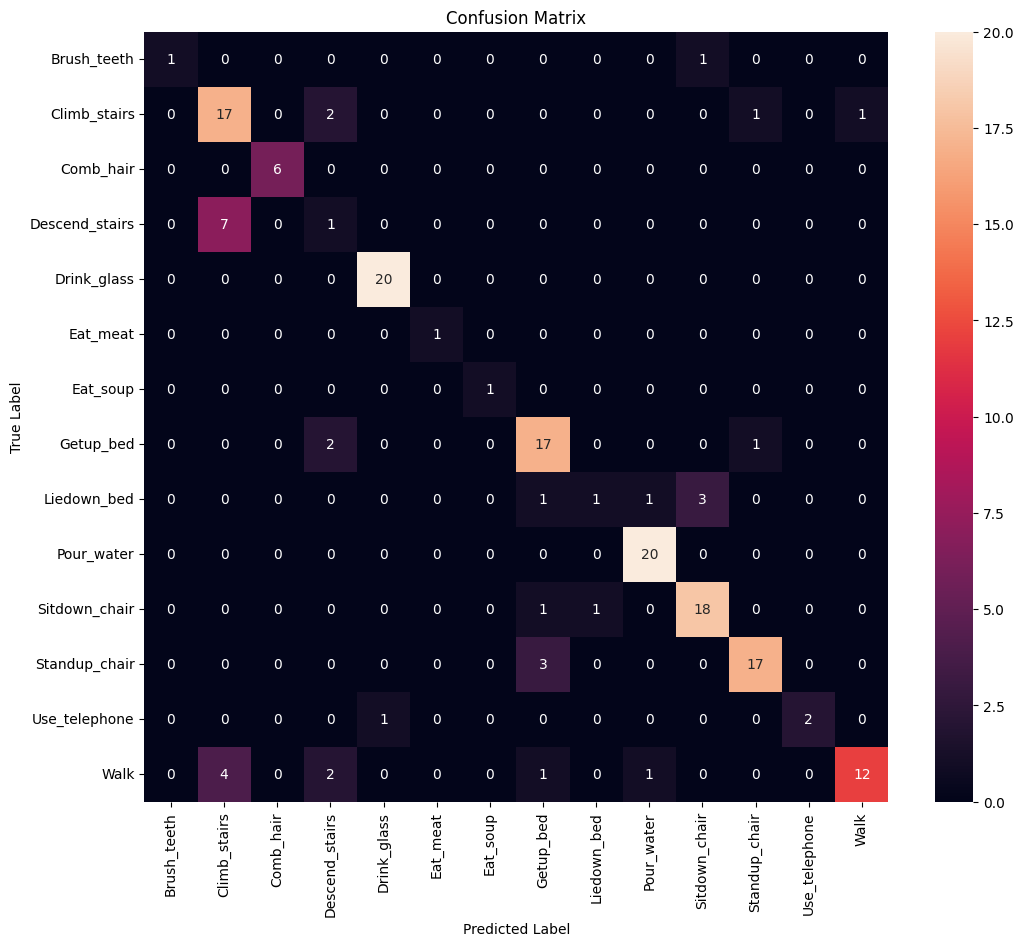

In [ ]:
# CLASSIFICATION AND EVALUATION
'''
Support Vector Machine with linear boundaries seems like the best choice
as you would expect clusters of different activity to be mostly clearly
separable.

Do the normal initialize, fit training data, test predictions with test data
then compute accuracy. Important to note here, no transforming test data
because there was no data engineering.
'''
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=activities)

# Plot confusion matrix trying stuff easier to see than the subtle shades of blue.
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=activities, yticklabels=activities)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


### Optimize

**2.2** (25 pts) Improve your classifier by modifying the size of the fixed-length segments and the number of cluster centers. Search for good values of these parameters in a principled way and print out the best you can find. (The search process may be time consuming.)

In [16]:
from sklearn.model_selection import StratifiedKFold
'''
Learned about StratifiedKFold as a means of keeping the data stratified
similar to the train test split, but for cross validation so trying it out.

After failing to get above segment_size of 150, I had to go add padding
to reach that segment size rather than just eliminate that size for tuning.

Also, after running the much larger grid search, I came back here with a
smaller number of parameters to more succintly meet what was being asked.
'''

def extract_segments(data, segment_size, step_size):
    segments = []
    data_length = len(data)
    num_features = data.shape[1]
    if data_length < segment_size:
        # Pad the data with zeros to reach segment_size
        padding = np.zeros((segment_size - data_length, num_features))
        padded_data = np.vstack((data, padding))
        segment = padded_data.flatten()
        segments.append(segment)
    else:
        for start in range(0, data_length - segment_size + 1, step_size):
            end = start + segment_size
            segment = data[start:end]
            segments.append(segment.flatten())
        # If no segments were created due to step size, take the last segment
        if not segments:
            segment = data[-segment_size:]
            segments.append(segment.flatten())
    return segments


def compute_histogram(segments, kmeans, k):
    hist = np.zeros(k)
    segments = np.array(segments)
    if segments.ndim == 1:
        segments = segments.reshape(1, -1)
    cluster_idxs = kmeans.predict(segments)
    for idx in cluster_idxs:
        hist[idx] += 1
    return hist

def evaluate_classifier(X, y, clf, cv):
    '''
    Do the same thing you normally do to evaluate a classifier but
    put in a function to make a more readable for loop.
    '''
    accuracies = []
    for train_idx, val_idx in cv.split(X, y):
        clf.fit(X[train_idx], y[train_idx])
        y_pred = clf.predict(X[val_idx])
        acc = accuracy_score(y[val_idx], y_pred)
        accuracies.append(acc)
    return np.mean(accuracies)

# Parameter ranges
segment_sizes = [75, 100, 125]  # Segment sizes to try
k_values = [40, 80, 90, 100, 115 ]         # Number of clusters to try
step_size = 25                         # Fixed step size

# Cross-validation setup
cv = StratifiedKFold(n_splits=3, shuffle=True)

best_accuracy = 0
best_params = {'segment_size': None, 'k': None}

for segment_size in segment_sizes:
    print(f"Evaluating segment size: {segment_size}")
    
    # Extract segments from training data
    all_segments = []
    for file_path in file_list_train:
        data = np.loadtxt(file_path)
        segments = extract_segments(data, segment_size, step_size)
        all_segments.extend(segments)
    all_segments = np.array(all_segments)
    
    for k in k_values:
        print(f"  Evaluating k: {k}")
        # Clustering
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(all_segments)
        
        # Build histograms for each trace in the training set
        X = []
        y = []
        for file_path, label in zip(file_list_train, labels_train):
            data = read_accelerometer_data(file_path)
            segments = extract_segments(data, segment_size, step_size)
            segments = np.array(segments)
            hist = compute_histogram(segments, kmeans, k)
            X.append(hist)
            y.append(label)
        X = np.array(X)
        y = np.array(y)
        
        # Classifier
        clf = SVC(kernel='linear', random_state=42)
        
        # Cross-validation evaluation
        accuracy = evaluate_classifier(X, y, clf, cv)
        print(f"    Cross-validation Accuracy: {accuracy:.4f}")
        
        # Update best parameters if current accuracy is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['segment_size'] = segment_size
            best_params['k'] = k
            best_kmeans = kmeans  # Save the best kmeans model
            best_X_train = X
            best_y_train = y


Evaluating segment size: 75
  Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.8048
  Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.8107
  Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.8182
  Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.8018
  Evaluating k: 115


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.8182
Evaluating segment size: 100
  Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.8107
  Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.8152
  Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.7958
  Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.8465
  Evaluating k: 115


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.8212
Evaluating segment size: 125
  Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.8108
  Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.8182
  Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.8212
  Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


    Cross-validation Accuracy: 0.8376
  Evaluating k: 115
    Cross-validation Accuracy: 0.8182


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


### Evaluate

**2.3** (25 pts) Print out the accuracy and confusion matrix of the best classifier you found.


Best Parameters:
Segment Size: 100
Number of Clusters (k): 100
Best Cross-validation Accuracy: 0.8465

Test Accuracy: 0.8393


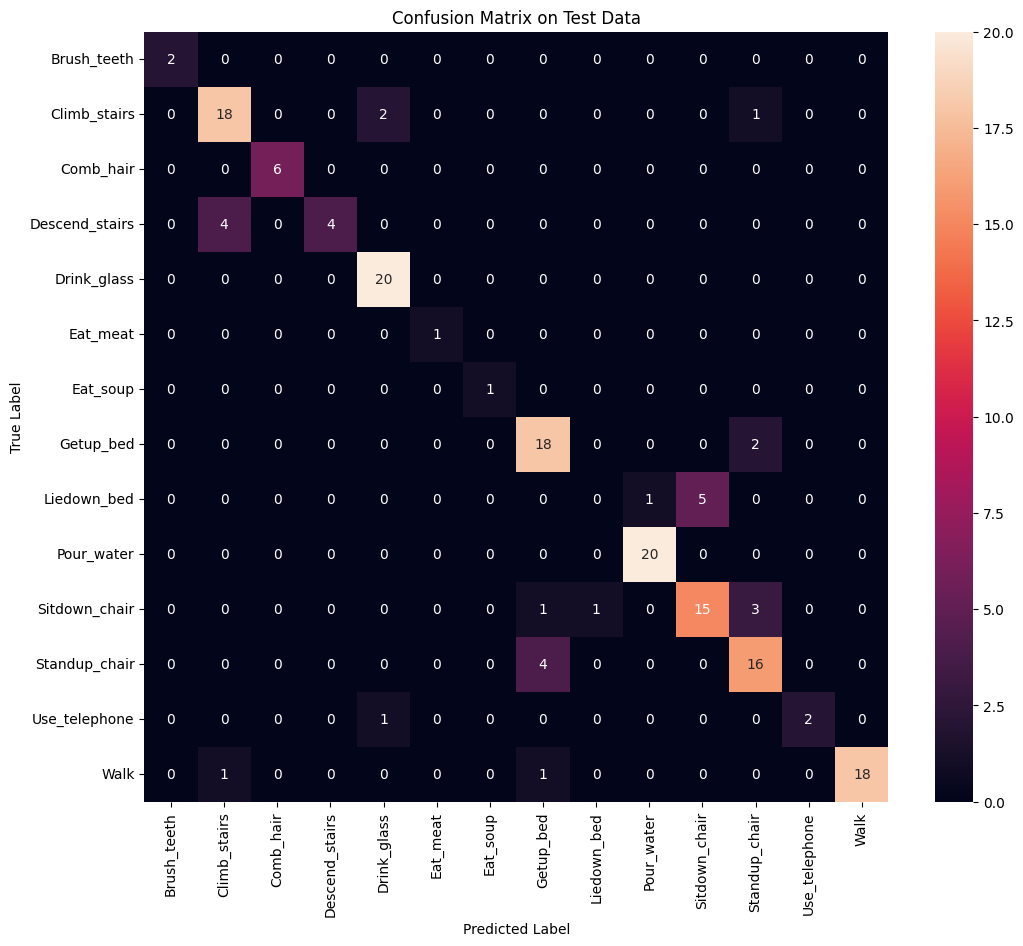

In [ ]:

print("\nBest Parameters:")
print(f"Segment Size: {best_params['segment_size']}")
print(f"Number of Clusters (k): {best_params['k']}")
print(f"Best Cross-validation Accuracy: {best_accuracy:.4f}")

# Make a "best" classifier
clf_best = SVC(kernel='linear')
clf_best.fit(best_X_train, best_y_train)

# Build histograms for test data and run through with the params that produced the best classifier
X_test = []
y_test = []
for file_path, label in zip(file_list_test, labels_test):
    data = read_accelerometer_data(file_path)
    segments = extract_segments(data, best_params['segment_size'], step_size) # Here
    segments = np.array(segments)
    hist = compute_histogram(segments, best_kmeans, best_params['k']) # Here
    X_test.append(hist)
    y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Execute and Evaluate
y_pred = clf_best.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=activities)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=activities, yticklabels=activities)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix on Test Data')
plt.show()

### Interpret

**2.4** (25 pts) Explain in two or three paragraphs how you found your parameters and why your chosen parameters perform well.

WRITE YOUR ANSWER HERE:

I chose to conduct a fairly robust grid search of step sizes, segment sizes, and cluster sizes. The adjustment of the step size helped to create overlapping segments to better capture action and transition between actions because real human activity changes gradually relative to data capture speed, and adjusting segment_size was another measure of accomplishing this to ensure robustness. Adjusting the cluster sizes is a natural choice for tuning a classifier using k-means clustering.

As you can see below, the robust grid search was conducted here so as not to affect autograding, and the most performant parameters were placed above to accomplish the asked task. The most interesting thing here was the lack of generalization improvement when running the top models. No matter if the top accuracy improved, the testing accuracy hovered between 80-81% no matter the step, segment, or cluster sizes, though you can see clear averages here from the best models regarding segment size and cluster size.

For my own edification, I ultimately ran Support Vector Machines with different kernels, a Random Forest Classifier, k-NN, and XGBoost (which we'd never done, just wanted to try the popular method). This really showed me the importance of understanding the theoretical reasons behind choosing a classifier as none of the other classifiers was even able to get above 75% ish in testing accuracy and most performed below 70%. This was very eye opening to see the relative weaknesses of different classifiers in very specific datasets. I believe that's most important here where there really is a lack of an actual number of features, but those features delineate very different label outcomes. That's where the simplicity of the linear boundaries from an SVM really shines through, and this was a great exercise to understand that.



In [ ]:
'''
Reimport packages so I can work on this cell without running all the previous cells

Running this because I was unhappy with the generalization, and I wanted to perform
a more robust grid search to determine more reasonable interpretations.
'''

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

def read_accelerometer_data(file_path):
    data = np.loadtxt(file_path)
    return data

def extract_segments(data, segment_size, step_size):
    segments = []
    data_length = len(data)
    num_features = data.shape[1]
    if data_length < segment_size:
        # Pad the data with zeros to reach segment_size
        padding = np.zeros((segment_size - data_length, num_features))
        padded_data = np.vstack((data, padding))
        segment = padded_data.flatten()
        segments.append(segment)
    else:
        for start in range(0, data_length - segment_size + 1, step_size):
            end = start + segment_size
            segment = data[start:end]
            segments.append(segment.flatten())
        # If no segments were created due to step size, take the last segment
        if not segments:
            segment = data[-segment_size:]
            segments.append(segment.flatten())
    return segments

def compute_histogram(segments, kmeans, k):
    hist = np.zeros(k)
    segments = np.array(segments)
    if segments.ndim == 1:
        segments = segments.reshape(1, -1)
    cluster_idxs = kmeans.predict(segments)
    for idx in cluster_idxs:
        hist[idx] += 1
    return hist

def evaluate_classifier(X, y, clf, cv):
    '''
    Do the same thing you normally do to evaluate a classifier but
    put in a function to make a more readable for loop.
    '''
    accuracies = []
    for train_idx, val_idx in cv.split(X, y):
        clf.fit(X[train_idx], y[train_idx])
        y_pred = clf.predict(X[val_idx])
        acc = accuracy_score(y[val_idx], y_pred)
        accuracies.append(acc)
    return np.mean(accuracies)

# Parameter ranges
segment_sizes = [x for x in range(50, 155, 5)]  # Segment sizes to try
k_values = [x for x in range(30, 160, 10)]      # Number of clusters to try
step_sizes = [x for x in range(20, 60, 10)]     # Step sizes to try

# Cross-validation setup
cv = StratifiedKFold(n_splits=3, shuffle=True)

# List to store top 5 models
top_models = []  # Each element will be a tuple: (accuracy, params, kmeans, X_train, y_train)

for step_size in step_sizes:
    print(f"Evaluating step size: {step_size}")
    for segment_size in segment_sizes:
        print(f"  Evaluating segment size: {segment_size}")
        
        # Extract segments from training data
        all_segments = []
        for file_path in file_list_train:
            data = read_accelerometer_data(file_path)
            segments = extract_segments(data, segment_size, step_size)
            all_segments.extend(segments)
        all_segments = np.array(all_segments)
        
        for k in k_values:
            print(f"    Evaluating k: {k}")
            # Clustering
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(all_segments)
            
            # Build histograms for each trace in the training set
            X = []
            y = []
            for file_path, label in zip(file_list_train, labels_train):
                data = read_accelerometer_data(file_path)
                segments = extract_segments(data, segment_size, step_size)
                hist = compute_histogram(segments, kmeans, k)
                X.append(hist)
                y.append(label)
            X = np.array(X)
            y = np.array(y)
            
            # Classifier
            clf = SVC(kernel='linear', random_state=42)
            
            # Cross-validation evaluation
            accuracy = evaluate_classifier(X, y, clf, cv)
            print(f"      Cross-validation Accuracy: {accuracy:.4f}")
            
            # Store the model if it's among the top 5
            params = {'step_size': step_size, 'segment_size': segment_size, 'k': k}
            model_info = (accuracy, params, kmeans, X, y)
            top_models.append(model_info)
            # Sort the models by accuracy in descending order
            top_models = sorted(top_models, key=lambda x: x[0], reverse=True)
            # Keep only the top 5 models
            top_models = top_models[:5]

Evaluating step size: 20
  Evaluating segment size: 50
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7809
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7720
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7839
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7869
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7720
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
  Evaluating segment size: 55
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7794
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8047
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7884
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7958
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8271
  Evaluating segment size: 60
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7974
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7928
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7884
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
  Evaluating segment size: 65
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7943
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8123
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8196
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
  Evaluating segment size: 70
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8047
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7958
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7809
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7943
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8123
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8138
  Evaluating segment size: 75
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8032
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7943
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
  Evaluating segment size: 80
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7839
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8196
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
  Evaluating segment size: 85
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8181
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8078
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7898
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
  Evaluating segment size: 90
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7929
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8271
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8108
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
  Evaluating segment size: 95
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8257
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8181
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8093
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8108
  Evaluating segment size: 100
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8360
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8062
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8390
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
  Evaluating segment size: 105
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8302
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8406
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
  Evaluating segment size: 110
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8390
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8257
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
  Evaluating segment size: 115
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8078
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8391
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8465
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
  Evaluating segment size: 120
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8375
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8421
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8525
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
  Evaluating segment size: 125
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8136
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8317
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8569
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8196
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
  Evaluating segment size: 130
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8123
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8287
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8360
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8375
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8375
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8242
  Evaluating segment size: 135
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8242
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8361
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8062
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8405
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8390
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8271
  Evaluating segment size: 140
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7928
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8004
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8093
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8242
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8450
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8181
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8435
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8257
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8093
  Evaluating segment size: 145
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7943
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8420
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8554
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8242
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8271
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8287
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8330
  Evaluating segment size: 150
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7600
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8196
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8361
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8376
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8420
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8376
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
Evaluating step size: 30
  Evaluating segment size: 50
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7884
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7720
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7794
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7646
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
  Evaluating segment size: 55
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7884
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8108
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7898
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
  Evaluating segment size: 60
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7869
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7855
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7989
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7794
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7943
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8376
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8017
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
  Evaluating segment size: 65
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7883
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7914
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8108
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7809
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
  Evaluating segment size: 70
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7989
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8078
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7959
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8108
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
  Evaluating segment size: 75
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8062
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8480
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7869
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7944
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7914
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
  Evaluating segment size: 80
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7869
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8435
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8332
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8494
  Evaluating segment size: 85
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8093
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8420
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8420
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8315
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8420
  Evaluating segment size: 90
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8181
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8391
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8271
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
  Evaluating segment size: 95
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8361
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7929
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8465
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8420
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8569
  Evaluating segment size: 100
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7972
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8420
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8272
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
  Evaluating segment size: 105
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7928
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8420
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8242
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8287
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8390
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8450
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8360
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8062
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
  Evaluating segment size: 110
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8391
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8093
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8524
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8629
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8376
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8271
  Evaluating segment size: 115
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7958
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8450
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8420
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8375
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8405
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8420
  Evaluating segment size: 120
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8465
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8196
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8465
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8242
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8435
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8242
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8390
  Evaluating segment size: 125
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8510
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8406
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8390
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8436
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8465
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8271
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8345
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8196
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
  Evaluating segment size: 130
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8271
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8376
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8376
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8495
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8257
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8376
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
  Evaluating segment size: 135
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8450
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8271
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8361
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8093
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
  Evaluating segment size: 140
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8062
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8391
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8554
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8390
  Evaluating segment size: 145
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8465
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8196
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8435
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8480
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8525
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
  Evaluating segment size: 150
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8181
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
Evaluating step size: 40
  Evaluating segment size: 50
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7705
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7750
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7869
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7676
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7631
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7809
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7765
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7497
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7676
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7571
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7839
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7586
  Evaluating segment size: 55
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7704
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7735
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7690
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7780
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7720
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7884
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7884
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8002
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7868
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
  Evaluating segment size: 60
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7884
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7869
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8078
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7795
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
  Evaluating segment size: 65
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7824
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7987
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7884
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7809
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7943
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7735
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8271
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7869
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7914
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7959
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
  Evaluating segment size: 70
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7810
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7974
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7795
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7884
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7912
  Evaluating segment size: 75
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7943
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7928
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8151
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7914
  Evaluating segment size: 80
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7974
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7929
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7869
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7943
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8093
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
  Evaluating segment size: 85
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7780
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8108
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8093
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
  Evaluating segment size: 90
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8153
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8420
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8062
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8242
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
  Evaluating segment size: 95
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7929
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8138
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
  Evaluating segment size: 100
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8242
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8405
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8062
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
  Evaluating segment size: 105
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8196
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7959
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8123
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8138
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8242
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8017
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
  Evaluating segment size: 110
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8331
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7824
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8108
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
  Evaluating segment size: 115
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8181
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8257
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7974
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
  Evaluating segment size: 120
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8062
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8391
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8539
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8435
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
  Evaluating segment size: 125
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8346
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8465
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8272
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
  Evaluating segment size: 130
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8495
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8242
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8361
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8242
  Evaluating segment size: 135
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8108
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8093
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8257
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8420
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
  Evaluating segment size: 140
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7824
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8405
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8078
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
  Evaluating segment size: 145
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8405
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8569
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8242
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8360
  Evaluating segment size: 150
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7929
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8435
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8257
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8361
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
Evaluating step size: 50
  Evaluating segment size: 50
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7407
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7526
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7645
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7571
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7542
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7631
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7556
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7750
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7780
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7735
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7839
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7793
  Evaluating segment size: 55
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7199
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7839
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7690
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7928
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7511
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7660
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7675
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7571
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7868
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7497
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7720
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7616
  Evaluating segment size: 60
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7496
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7466
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7720
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7616
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7571
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7719
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7601
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8062
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7704
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7556
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7586
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7675
  Evaluating segment size: 65
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7810
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7720
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7690
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7794
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7586
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7586
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7794
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7914
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7750
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7883
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7795
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7839
  Evaluating segment size: 70
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7824
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7944
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7914
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7779
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7958
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7705
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7869
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7660
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
  Evaluating segment size: 75
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7749
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7840
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7675
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7750
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7690
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7869
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7884
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7869
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
  Evaluating segment size: 80
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8123
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7735
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7959
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7958
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7974
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7825
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7749
  Evaluating segment size: 85
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7959
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7854
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7884
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7839
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7809
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7958
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7899
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7839
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7824
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7825
  Evaluating segment size: 90
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7958
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8093
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8093
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8078
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7914
  Evaluating segment size: 95
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7958
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8078
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7898
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8196
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8151
  Evaluating segment size: 100
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7840
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8078
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8123
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
  Evaluating segment size: 105
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7824
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7943
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7928
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7958
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7913
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7914
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8166
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7959
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
  Evaluating segment size: 110
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8166
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7720
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7943
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7883
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8018
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8047
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7884
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7943
  Evaluating segment size: 115
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7883
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8302
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8078
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7944
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8032
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8271
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7913
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8077
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
  Evaluating segment size: 120
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7839
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7988
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8092
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8093
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7913
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8212
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
  Evaluating segment size: 125
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8093
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7929
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
  Evaluating segment size: 130
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8241
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8226
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8078
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
  Evaluating segment size: 135
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7809
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8316
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8301
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8078
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7973
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8211
  Evaluating segment size: 140
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8063
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8465
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8227
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8108
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7824
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8048
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
  Evaluating segment size: 145
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8062
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8078
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8376
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8123
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8137
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8345
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8167
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8405
    Evaluating k: 150


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
  Evaluating segment size: 150
    Evaluating k: 30


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8182
    Evaluating k: 40


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 50


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.7869
    Evaluating k: 60


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8256
    Evaluating k: 70


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8107
    Evaluating k: 80


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 90


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8197
    Evaluating k: 100


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8122
    Evaluating k: 110


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8286
    Evaluating k: 120


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8003
    Evaluating k: 130


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8033
    Evaluating k: 140


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


      Cross-validation Accuracy: 0.8152
    Evaluating k: 150
      Cross-validation Accuracy: 0.8152


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-C8y3MhrL-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(



Top 5 Models:
Model 1:
  Step Size: 30
  Segment Size: 110
  Number of Clusters (k): 120
  Cross-validation Accuracy: 0.8629

Model 2:
  Step Size: 30
  Segment Size: 95
  Number of Clusters (k): 150
  Cross-validation Accuracy: 0.8569

Model 3:
  Step Size: 40
  Segment Size: 145
  Number of Clusters (k): 120
  Cross-validation Accuracy: 0.8569

Model 4:
  Step Size: 20
  Segment Size: 125
  Number of Clusters (k): 120
  Cross-validation Accuracy: 0.8569

Model 5:
  Step Size: 20
  Segment Size: 145
  Number of Clusters (k): 90
  Cross-validation Accuracy: 0.8554


Evaluating Model 1 on Test Data:
  Test Accuracy: 0.8095


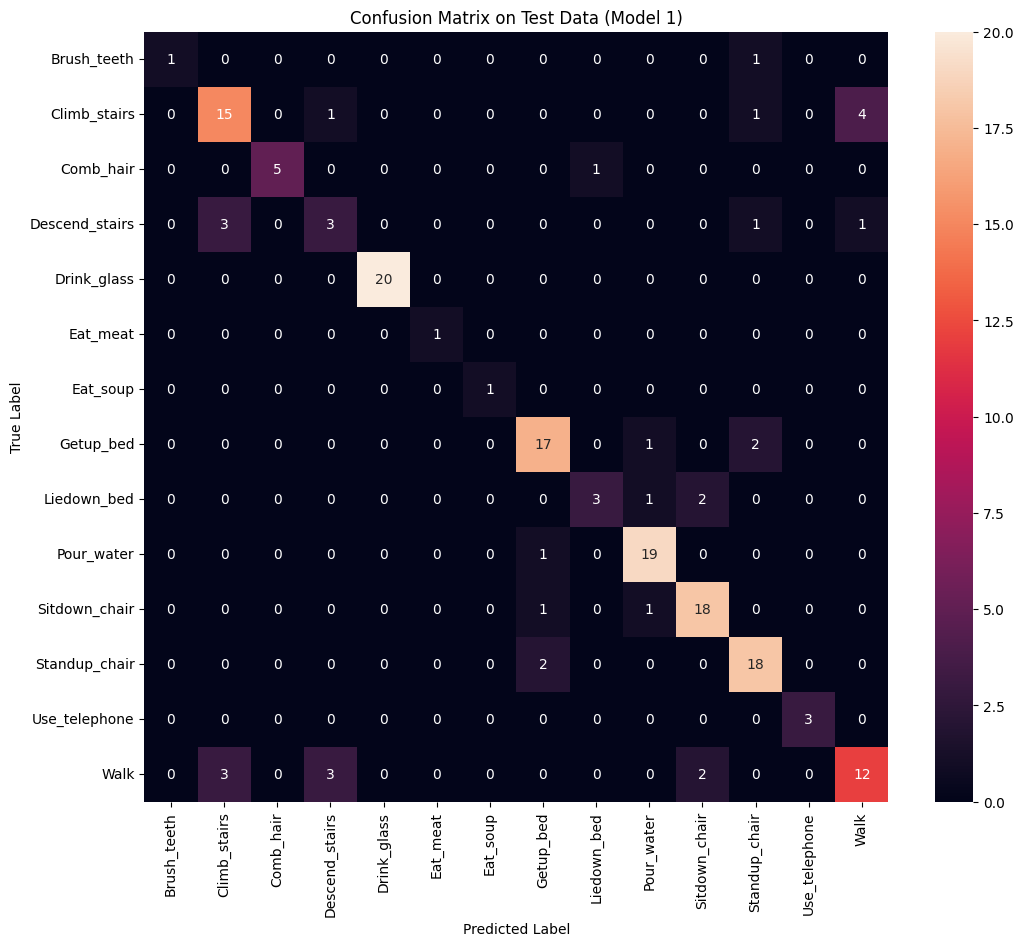


Evaluating Model 2 on Test Data:
  Test Accuracy: 0.8036


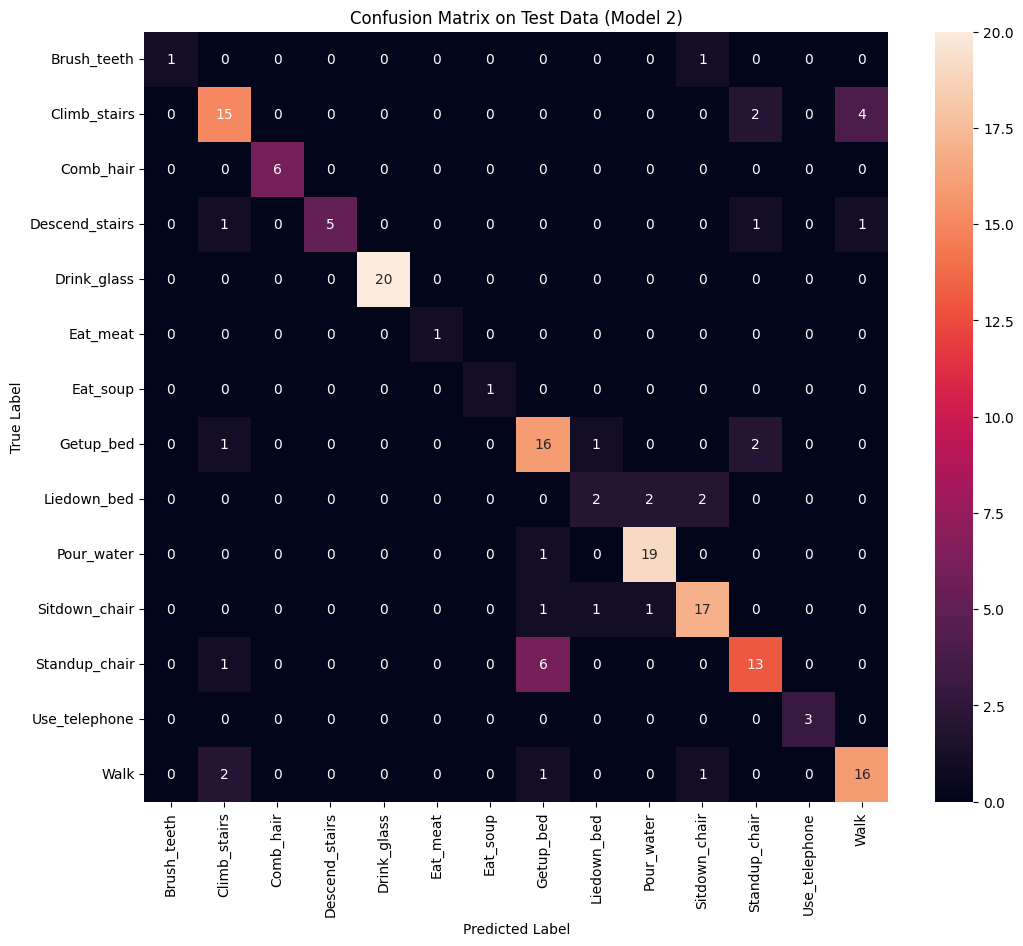


Evaluating Model 3 on Test Data:
  Test Accuracy: 0.8095


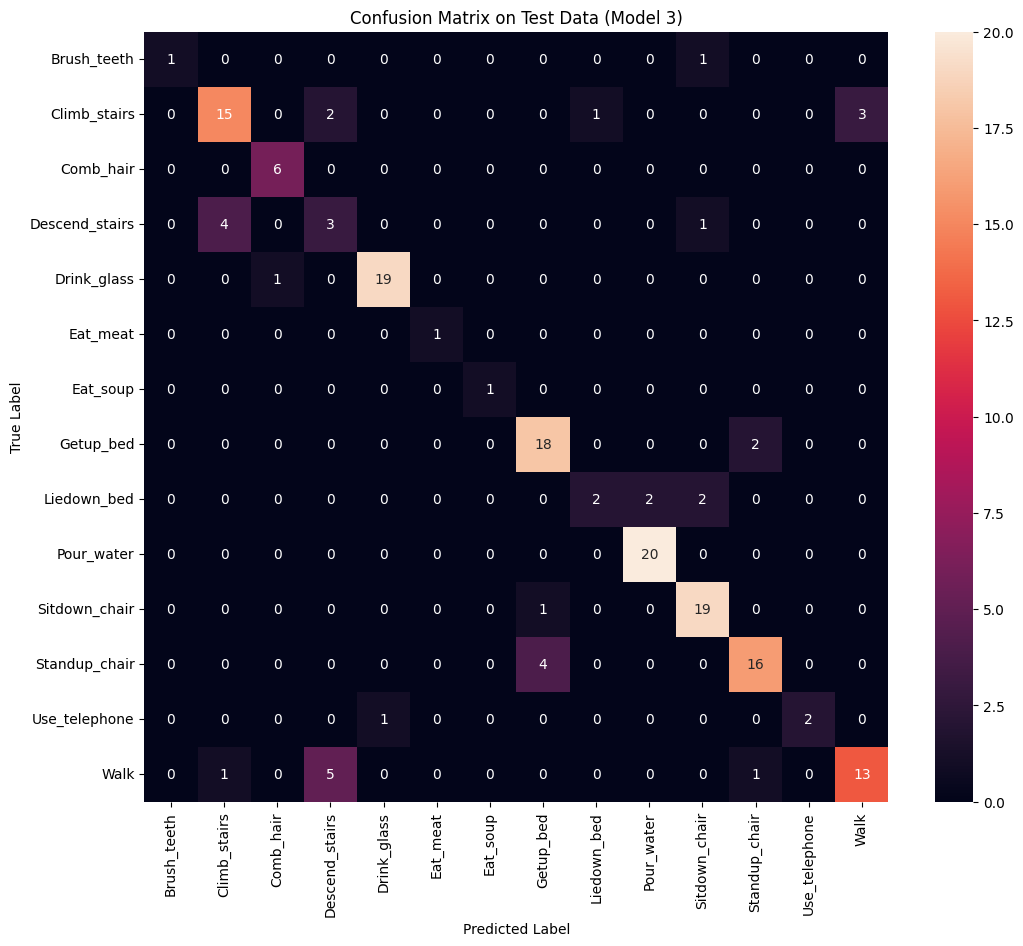


Evaluating Model 4 on Test Data:
  Test Accuracy: 0.8095


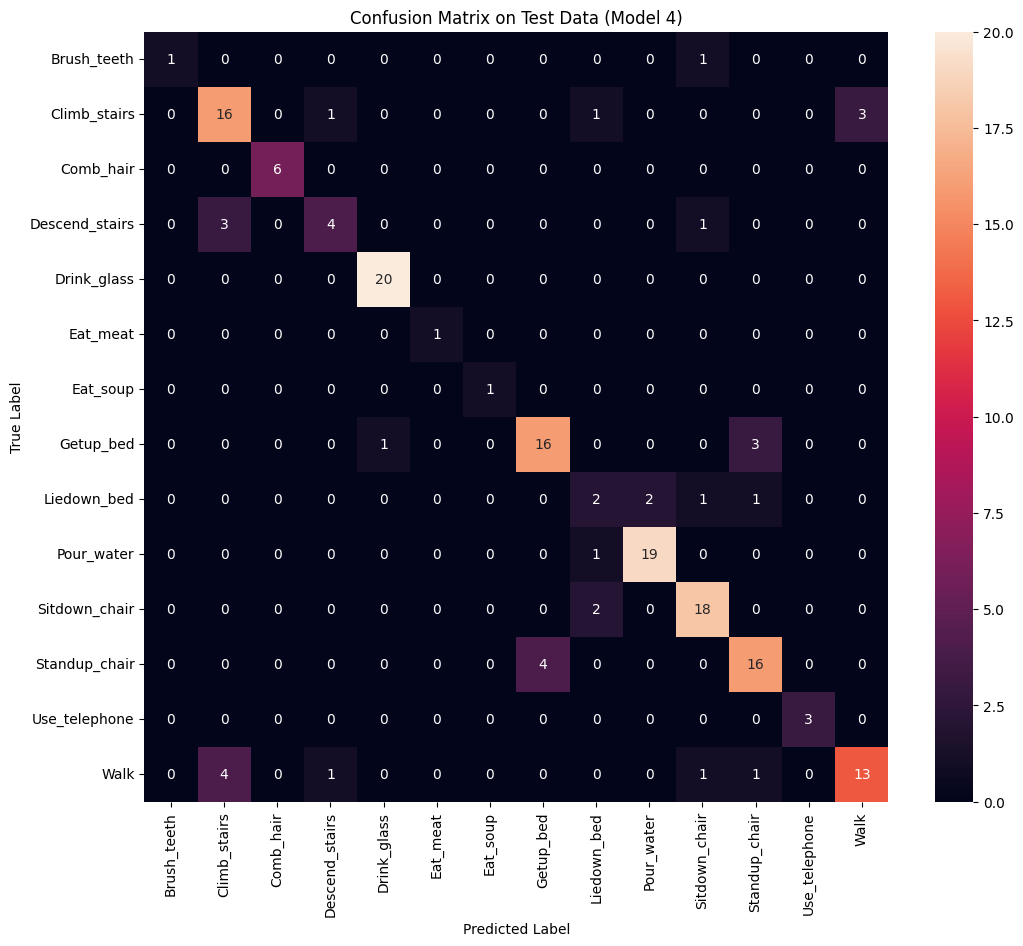


Evaluating Model 5 on Test Data:
  Test Accuracy: 0.7917


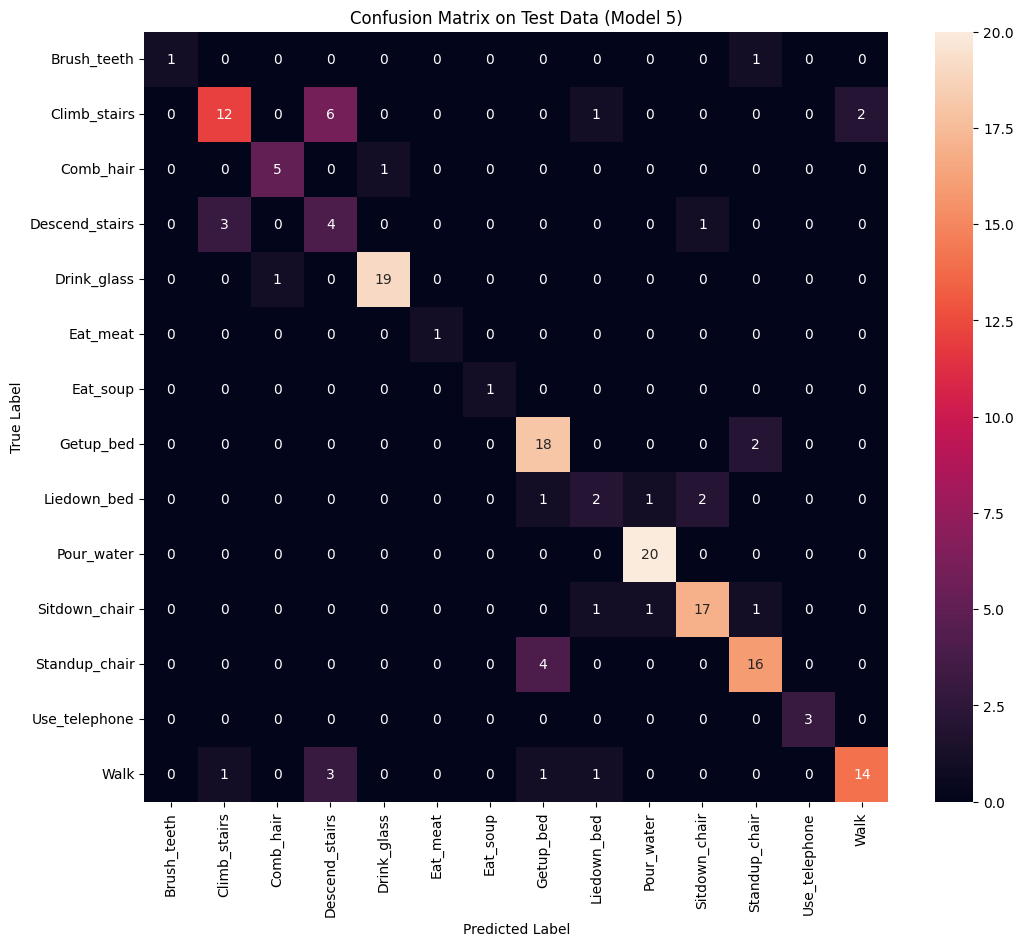

In [81]:
# Display the best parameters
print("\nTop 5 Models:")
for idx, (accuracy, params, _, _, _) in enumerate(top_models, 1):
    print(f"Model {idx}:")
    print(f"  Step Size: {params['step_size']}")
    print(f"  Segment Size: {params['segment_size']}")
    print(f"  Number of Clusters (k): {params['k']}")
    print(f"  Cross-validation Accuracy: {accuracy:.4f}\n")

# Evaluate each of the top 5 models on the test set
for idx, (accuracy, params, kmeans_model, X_train, y_train) in enumerate(top_models, 1):
    print(f"\nEvaluating Model {idx} on Test Data:")
    # Train the classifier on the full training data
    clf_best = SVC(kernel='linear')
    clf_best.fit(X_train, y_train)
    
    # Build histograms for test data
    X_test = []
    y_test = []
    for file_path, label in zip(file_list_test, labels_test):
        data = read_accelerometer_data(file_path)
        segments = extract_segments(data, params['segment_size'], params['step_size'])
        hist = compute_histogram(segments, kmeans_model, params['k'])
        X_test.append(hist)
        y_test.append(label)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # Predict on test data
    y_pred = clf_best.predict(X_test)
    
    # Compute accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=activities)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    # sns.heatmap(cm, annot=True, fmt='d', xticklabels=activities, yticklabels=activities, cmap='Blues')
    sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix on Test Data (Model {idx})')
    plt.show()

**2.4** (25 pts) Explain in two or three paragraphs how you found your parameters and why your chosen parameters perform well.

WRITE YOUR ANSWER HERE: